In [1]:
import numpy as np
import pandas as pd

from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split

import lightgbm as lgbm

from IPython.display import display

In [2]:
df = pd.read_csv('data/train_final.csv', index_col='Id')
df_ult = pd.read_csv('data/test_final.csv', index_col='Id')

X = df.drop('Y', axis='columns').values
y = df['Y'].values

X_ult = df_ult.values

scale_pos_weight = len(y[y == 0])/len(y[y == 1])

In [4]:
df.drop('Y', axis='columns').corr()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24
f1,1.000000,-0.003391,-0.004638,0.014199,-0.004121,-0.003148,0.001298,0.021653,-0.000203,-0.012698,...,0.004943,0.029470,0.031858,-0.000300,-0.001946,0.002467,-0.008155,-0.009366,0.006847,-0.002102
f2,-0.003391,1.000000,0.026442,0.006225,0.006678,0.002049,-0.012170,0.009720,-0.011067,-0.006072,...,-0.003320,-0.004262,0.010071,0.011750,-0.003790,0.006677,0.018798,-0.008867,-0.001677,0.011586
f3,-0.004638,0.026442,1.000000,0.000483,-0.002410,-0.000694,0.000510,-0.007852,-0.002839,-0.000573,...,-0.002022,-0.000046,-0.008306,-0.001172,-0.002480,0.000133,0.003409,-0.000812,-0.000196,-0.002820
f4,0.014199,0.006225,0.000483,1.000000,0.009693,-0.006871,0.038115,0.017708,-0.008797,-0.002021,...,0.000530,0.005781,0.066988,-0.001787,0.007615,0.006043,-0.005255,0.008059,0.000067,-0.003628
f5,-0.004121,0.006678,-0.002410,0.009693,1.000000,0.008260,0.005845,-0.009440,-0.003951,-0.001085,...,-0.002781,-0.001335,0.004467,0.000422,0.010716,-0.008261,-0.004549,-0.007948,-0.001700,-0.004421
f6,-0.003148,0.002049,-0.000694,-0.006871,0.008260,1.000000,0.006861,0.001224,0.001379,0.013056,...,0.009897,0.007094,0.001291,0.015064,-0.005578,-0.002008,-0.002715,0.006413,-0.001689,-0.006430
f7,0.001298,-0.012170,0.000510,0.038115,0.005845,0.006861,1.000000,0.000741,0.002666,-0.011992,...,-0.012774,0.000034,0.019590,-0.005491,0.015218,0.017307,0.002906,-0.007056,0.001074,0.000610
f8,0.021653,0.009720,-0.007852,0.017708,-0.009440,0.001224,0.000741,1.000000,-0.008102,-0.007583,...,-0.019469,-0.008580,-0.184269,0.003078,0.166054,-0.000723,-0.015716,0.006589,-0.005096,-0.004944
f9,-0.000203,-0.011067,-0.002839,-0.008797,-0.003951,0.001379,0.002666,-0.008102,1.000000,-0.001562,...,0.002999,0.011958,-0.000545,-0.017294,-0.000429,0.005832,-0.009139,0.000264,-0.001326,-0.001005
f10,-0.012698,-0.006072,-0.000573,-0.002021,-0.001085,0.013056,-0.011992,-0.007583,-0.001562,1.000000,...,0.001688,-0.006509,0.006255,-0.004871,-0.006443,-0.005890,-0.006236,-0.005660,-0.000736,0.012982


In [59]:
def get_ind(mask): return [index for index, mask_ele in enumerate(mask) if mask_ele==True]

def get_best_ind(importances, start=7, number=5):
    ranked_features = sorted(range(len(importances)), key=lambda i: importances[i], reverse=True)
    return [ranked_features[:i] for i in range(start, start + number)]

def get_best_features(model, data, step=1):
    rfecv = RFECV(estimator=model, step=step, cv=StratifiedKFold(5), scoring='roc_auc', n_jobs=-1)
    return rfecv.fit(data, y)

def get_clf():
    return lgbm.LGBMClassifier(n_estimators=500,
                               learning_rate=0.1, 
                               boosting_type='goss', 
                               max_depth=5, 
                               num_leaves=33,
                               objective='binary', 
                               scale_pos_weight=scale_pos_weight)

In [ ]:
def alter_params(params, dec):
    new_params = {}
    new_params['n_estimators'] = [round(params['n_estimators'] + np.ceil(dec)), 
                                  round(params['n_estimators'] - np.ceil(dec))]
    new_params['learning_rate'] = [params['learning_rate'] + 0.001 * dec, 
                                   params['learning_rate'] - 0.001 * dec]
    new_params['n_estimators'] = [round(params['num_leaves'] + np.ceil(0.05 * dec)), 
                                  round(params['num_leaves'] - np.ceil(0.05 * dec))]
    new_params['reg_alpha'] = [params['reg_alpha'] * (1 + (0.02 * dec)), 
                               params['reg_alpha'] * (1 - (0.02 * dec))]
    new_params['reg_lambda'] = [params['reg_lambda'] + (0.05 * dec), 
                                params['reg_lambda'] - (0.05 * dec)]
    return new_params

start_var_param = [{
    'n_estimators':                  500,
    'learning_rate':                 0.1, 
    'num_leaves':                    33, 
    'reg_alpha':                     0.001, 
    'reg_lambda':                    1, 
}]

In [12]:
fix_param = {
    'boosting_type':                 'goss', 
    'max_depth':                     5, 
    'objective':                     'binary', 
    'scale_pos_weight':              scale_pos_weight,
    'n_jobs':                        -1
}

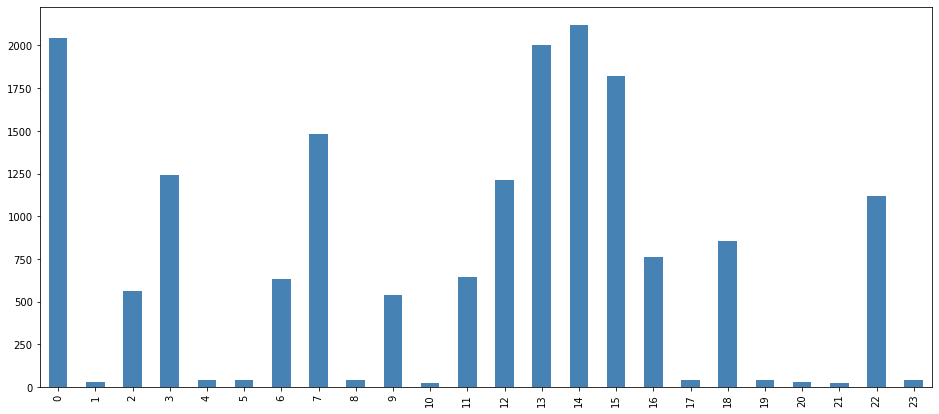

In [116]:
clf = clfs[2].fit(X, y)
pd.Series(clf.feature_importances_, index=list(range(X.shape[1]))).plot.bar(color='steelblue', figsize=(16, 7));

In [117]:
rankings = get_best_features(clfs[2], X).ranking_

print(get_ind(np.isin(rankings, [1])))
print(get_ind(np.isin(rankings, [1, 2, 3])))
print(get_ind(np.isin(rankings, [1, 2, 3, 4, 5])))

[0, 3, 7, 12, 13, 14, 15]
[0, 3, 7, 12, 13, 14, 15, 18, 22]
[0, 3, 7, 11, 12, 13, 14, 15, 16, 18, 22]


In [133]:
var_param = {'min_child_samples':             20,
             'learning_rate':                 0.1, 
             'num_leaves':                    31,
             'reg_alpha':                     0.000659,
             'reg_lambda':                    0.9}

def do_tune(tun_param, feats):
    grid = GridSearchCV(lgbm.LGBMClassifier(**fix_param, **var_param), 
                        tun_param, 
                        cv=StratifiedKFold(5), 
                        scoring='roc_auc', 
                        n_jobs=-1)
    
    grid.fit(X[:, feats], y)
    
    print(f'Best parameters {grid.best_params_}.')
    print(f'Best auc score is {grid.best_score_}.')
    
    clfs.append(grid.best_estimator_)

clfs = []
tun_param = [{'n_estimators':                  [910], # 895 to 915
              'min_child_weight':              [9e-7],
              'feature_fraction':              [0.25]}] #0.24 to 0.26
do_tune(tun_param, [3, 6, 7, 12, 13, 14, 15, 16, 18, 21])

tun_param = [{'n_estimators':                  [980], # 1000 to 970
              'min_child_weight':              [1e-7], 
              'feature_fraction':              [0.05]}] # 0.06 to 0.07
do_tune(tun_param, [0, 3, 7, 12, 13, 14, 15])

tun_param = [{'n_estimators':                  [845], # 844 to 847
              'min_child_weight':              [1e-7], 
              'feature_fraction':              [0.23],  # 0.2 to 0.25
              'seed':                          list(range(100))}]
do_tune(tun_param, [1, 3, 6, 7, 12, 13, 14, 15, 16, 18, 23])

tun_param = [{'n_estimators':                  [945], # 955 to 940
              'min_child_weight':              [1e-7], 
              'feature_fraction':              [0.38], # 0.41 to 0.35
              'seed':                          list(range(100))}]
do_tune(tun_param, [0, 1, 3, 6, 7, 12, 13, 14, 15, 16, 18, 23])


Best parameters {'feature_fraction': 0.38, 'min_child_weight': 1e-07, 'n_estimators': 945, 'seed': 55}.
Best auc score is 0.8961743884754645.
Best parameters {'feature_fraction': 0.38, 'min_child_weight': 1e-07, 'n_estimators': 945, 'seed': 121}.
Best auc score is 0.8963934561372057.


In [134]:
req_rows = 16384
sealed_feats = []

display('Re-training...')
preds_dfs = []
for feats, clf in zip(sealed_feats, clfs):
    clf.fit(X[:, feats], y)
    preds_dfs.append(pd.DataFrame(clf.predict_proba(X_ult[:, feats])[:, 1], 
                          index=list(range(req_rows, req_rows*2 + 1)), 
                          columns=['Y']))

display('Writing...')
for idx, df in enumerate(preds_dfs):
    df.index.name = 'Id'
    df.to_csv(f'submission_26_{idx}.csv', float_format='%.20f')
display('Done.')

'Re-training...'

'Writing...'

'Done.'